# Sentiment Analysis of Yelp Reviews - Part 2

This project aims to analyse the reviews of a single restaurant to determine the general sentiment of people leaving reviews, particularly on what they think of specific aspects of their dining experience - the food, service and wait times. This method is applicable to any retaurant, and is a quick way for restaurants to determine the aspects people liked and did not like, and use it to improve it for future customers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
#!pip install afinn
from afinn import Afinn
import operator
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize

## Data Retrieval

##### This project will focus primarily on the analysis of reviews of the restaurant with the above business ID (Mon Ami Gabi).

In [2]:
# Load the dataset created above
url = "top_restaurant_reviews.csv"
df_company = pd.read_csv(url)
df_company.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,mEh1m_QsUwzZuhtx4TdcFA,x5NpvWNS1cF_4bINIBPGzQ,4JNXUYY8wbaaDmk3BPzlWw,5,0,0,0,Hard to beat this location for table side ente...,2015-07-28 08:57:56
1,9RQNNTuvjmBqhdBUAdB1Ng,m5cBT7OYfn0HM0d-RCsdZQ,4JNXUYY8wbaaDmk3BPzlWw,5,7,6,5,"Sometimes, all a girl needs is a great steak.\...",2014-09-25 11:47:39
2,rgLkvhpTN3BZIJXDFpmj-A,ANsHMXjqFUTvZs0KQ7RB5Q,4JNXUYY8wbaaDmk3BPzlWw,2,0,0,0,"Mediocre food, very loud. Filet mignon au poi...",2015-08-19 06:18:34
3,dFn-P7DARHYhpEc0niEkHQ,2L4W7nak0F6AxFAeBhFI1w,4JNXUYY8wbaaDmk3BPzlWw,4,0,0,0,I have been here three times now and I keep on...,2013-05-07 03:53:59
4,dtFqvo73hMSt2zSw9LwTEQ,Oj_66IjmwmVdZTIz5xZXWg,4JNXUYY8wbaaDmk3BPzlWw,5,0,0,0,This place has such great atmosphere & ambianc...,2018-07-17 01:23:42


In [45]:
data = df_company[df_company.business_id=='4JNXUYY8wbaaDmk3BPzlWw']
data_text = pd.DataFrame()
data_text = data['text']

# Section 1
**This section contains analysis on the words used in all the reviews of Mon Ami Gabi, rather than each individual review.**

## Text Cleaning

The below code cleans up the code by removing stop words, punctuation, and special symobols that could add noise during the analysis.\
**Possible Drawback**: removing punctuation could add words that were not originally part of the dataset, such as 'ill' which is the modifed certion of 'i'll'.

In [304]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#STOPWORDS.add("food")
STOPWORDS.add("restaurant")
STOPWORDS.add("ordered")


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
data_text['text'] = data['text'].apply(clean_text)
data_text.head()

2661167    hard to beat this location for table side ente...
2661227    sometimes  all a girl needs is a great steakth...
2661348    mediocre food  very loud  filet mignon au poiv...
2661595    i have been here three times now and i keep on...
2661612    this place has such great atmosphere  ambiance...
Name: text, dtype: object

## Vectorization - unigram

Vectorization will create a large matrix that contains all the words in our corpus, and for each review, it will indicate whether a word is in the review or not. By default, vectorization keeps the 'ngram' value as 1. i.e. Each column in the matrix will have *one* word. I will continue the analysis with bigrams later in the projects (each column has *two* consecutive words).

In [295]:
corpus = data_text['text'].values
vectorizer_det = CountVectorizer()
vectorizer_det = vectorizer_det.fit(corpus)
vec=vectorizer_det.transform(corpus)

In [178]:
vocab_dict = vectorizer_det.vocabulary_
vocab = [] 
for key in vocab_dict.keys(): 
    vocab.append(key)

Let's take a look at some of the commonly occuring word in this company's reviews. We start by converting the dictionary of words into a tuple and sorting - as dictionaries by nature are not sorted.

## Analysis

[('good', 5604), ('great', 5478), ('steak', 4140), ('service', 4027), ('vegas', 3775), ('place', 3757), ('french', 3433), ('patio', 2867), ('time', 2814), ('like', 2676)]


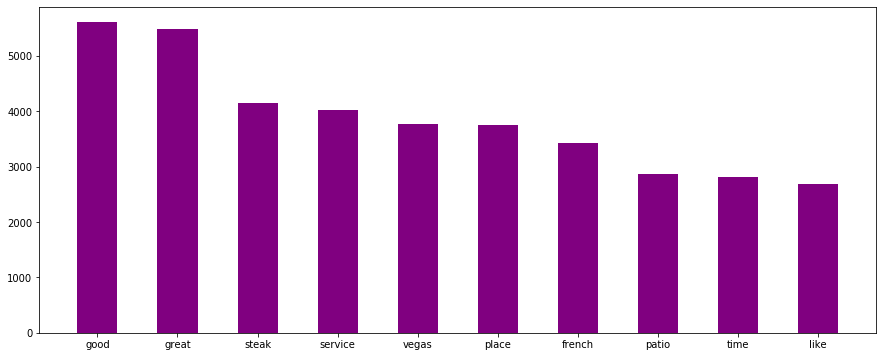

In [190]:
sum_words = vec.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vectorizer_det.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:10])

x, y = zip(*words_freq[:10]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'purple')
plt.show()
# color=['black', 'red', 'green', 'blue', 'cyan']

Some of the information that can be gathered just by looking at this graph, without even knowing the restaurant is that it is a French restaurant that is located in Vegas. The word patio occurs around 3000 times, but we dont know if that is a good or a bad reference. The same applies for the word 'steak' - we do not know whether people said the steak was good or bad, but as it occurred just over 4000 times in the reviews, we can conclude that a number of people ordered the steak there (maybe this place is famous for its steak!).

The word 'service' also occurs, but further analysis needs to be done to determine whether the service provided was good or bad.

Now that I have the top 10 words used in the reviews, I want to find out the top positive words, negative words and the neutral words. I will split by vocabulary into positive, negative and neutral lists based on the sentiment assigned by the AFINN algorithm.

In [209]:
af = Afinn()
positive_list = {}
negative_list = {}
neutral_list = {}

positive_sentiment = {}
negative_sentiment = {}
neutral_sentiment = {}

for key,value in vocab_dict.items():
    sentiment_score = af.score(key)
    if sentiment_score > 0.0:
        positive_list[key]=value
        positive_sentiment[key] = sentiment_score
    elif sentiment_score < 0.0:
        negative_list[key]=value
        negative_sentiment[key] = sentiment_score
    else:
        neutral_list[key]=value
        neutral_sentiment[key] = sentiment_score
    

### Top 10 positive words

[('good', 5604), ('great', 5478), ('like', 2676), ('delicious', 2360), ('nice', 2241), ('best', 2037), ('amazing', 1729), ('love', 1355), ('perfect', 1335), ('pretty', 1216)]


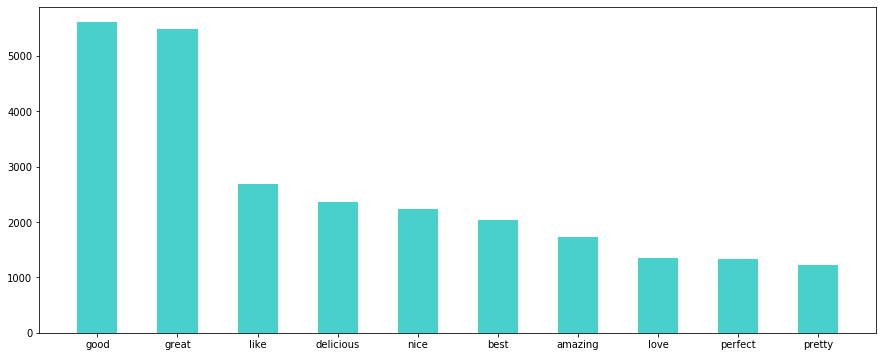

In [197]:
pos_words_freq = [(word, sum_words[0, idx]) for word, idx in     positive_list.items()]
pos_words_freq =sorted(pos_words_freq, key = lambda x: x[1], reverse=True)
print(pos_words_freq[:10])

x, y = zip(*pos_words_freq[:10]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'mediumturquoise')
plt.show()

The words 'great' and 'good' occur the most times out of all the words. Apart from this, some of the other top 10 positive words are shown above. The word 'pretty' also occurs over a thousand times, possibly indicating the way the restaurant looks. I would be able to get more information on this when I do the bigram analysis.

### Top 10 negative words

[('bad', 635), ('cut', 445), ('bloody', 401), ('hard', 374), ('disappointed', 370), ('stop', 276), ('ill', 271), ('wrong', 262), ('die', 231), ('rude', 159)]


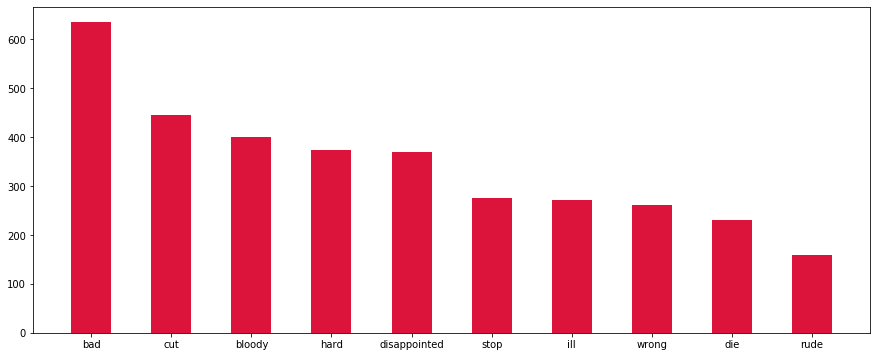

In [198]:
neg_words_freq = [(word, sum_words[0, idx]) for word, idx in negative_list.items()]
neg_words_freq =sorted(neg_words_freq, key = lambda x: x[1], reverse=True)
print(neg_words_freq[:10])

x, y = zip(*neg_words_freq[:10]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'crimson')
plt.show()

The top negative word is 'bad' which is fairly self-explanatory. However the second one is 'cut'. This does not necessarily indicate a negative sentiment in the context of reviews. It could be someting like 'the steak was so easy to cut', which would actually be positive review. More analysis can be done to determine the context in which this word is used.
The word 'ill' is also present in the top 10 words - as mentioned this could possibly be a side affect of applying text cleaning to remove punctuation and special characters. Again, deeper analysis is required to determine why that word is occuring over 200 times.

Another interesting thing to note is that the number of positive words is much higher than the number of negative words - indicating that this restaurant has more happy reviewers.

### Top 10 neutral words

[('steak', 4140), ('service', 4027), ('vegas', 3775), ('place', 3757), ('french', 3433), ('patio', 2867), ('time', 2814), ('one', 2585), ('bellagio', 2517), ('really', 2466)]


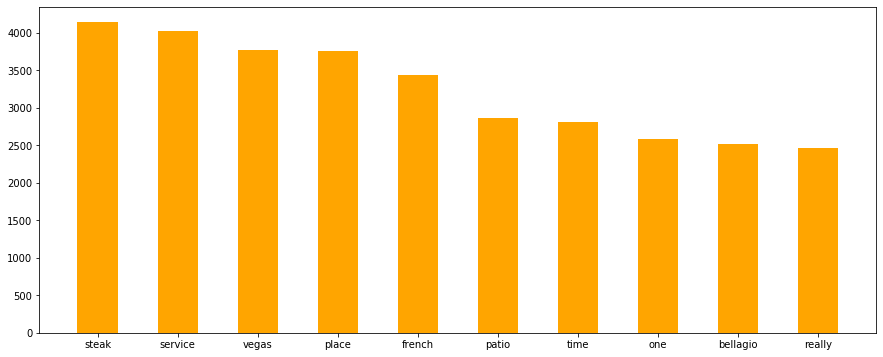

In [199]:
neut_words_freq = [(word, sum_words[0, idx]) for word, idx in neutral_list.items()]
neut_words_freq =sorted(neut_words_freq, key = lambda x: x[1], reverse=True)
print(neut_words_freq[:10])

x, y = zip(*neut_words_freq[:10]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'orange')
plt.show()

The neutral words give us clues about the restaurant, its location, and the food it sells. Presence of words like "Vegas" and "Bellagio" indicate its location. However, it does not add any useful information from what the first graph of **all** words provided.

### Sentiment Analysis

This sentiment analysis will be based on the sentiment scores assigned by AFINN's *score* function.

In [210]:
positive_sentiment_sorted = sorted(positive_sentiment.items(), key=operator.itemgetter(1),reverse=True)
negative_sentiment_sorted = sorted(negative_sentiment.items(), key=operator.itemgetter(1))
# Sorting the neutral array does not make sense, but I wanted to keep the format consistent with the + and - vocabs.
neutral_sentiment_sorted = sorted(neutral_sentiment.items(), key=operator.itemgetter(1))

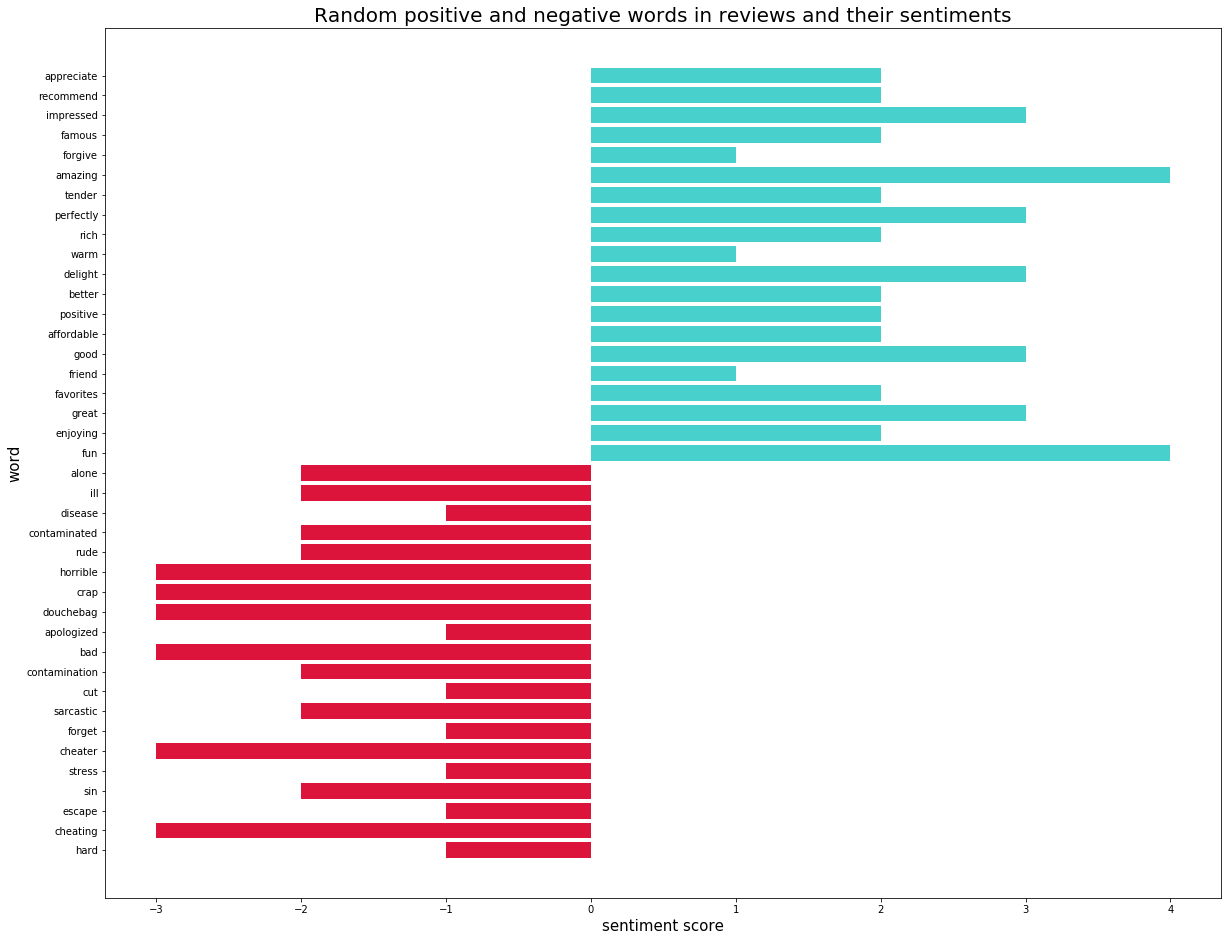

In [237]:
x, y = zip(*list(positive_sentiment.items())[:20])
a, b = zip(*list(negative_sentiment.items())[:20])
plt.figure(figsize=(20,16))
plt.barh(a, b, color = 'crimson')
plt.barh(x, y, color = 'mediumturquoise')
plt.xlabel("sentiment score",fontsize=15)
plt.ylabel("word",fontsize=15)
plt.title("Random positive and negative words in reviews and their sentiments", fontsize=20)

plt.show()

## Vectorization - bigram

In [305]:
vectorizer_det = CountVectorizer(ngram_range=(2,2))
vectorizer_det = vectorizer_det.fit(corpus)
vec=vectorizer_det.transform(corpus)

vocab_bigrams_dict = vectorizer_det.vocabulary_
vocab_bigrams = [] 
for key in vocab_bigrams_dict.keys(): 
    vocab_bigrams.append(key)

### Top bigrams

[('onion soup', 1051), ('bellagio fountains', 1017), ('view bellagio', 817), ('las vegas', 809), ('french onion', 750), ('steak frites', 729), ('eggs benedict', 594), ('filet mignon', 552), ('sit outside', 459), ('come back', 455), ('people watching', 446), ('water show', 439), ('bellagio fountain', 432), ('go back', 405), ('great view', 404), ('great food', 404), ('next time', 404), ('service great', 396), ('really good', 395), ('french toast', 382)]


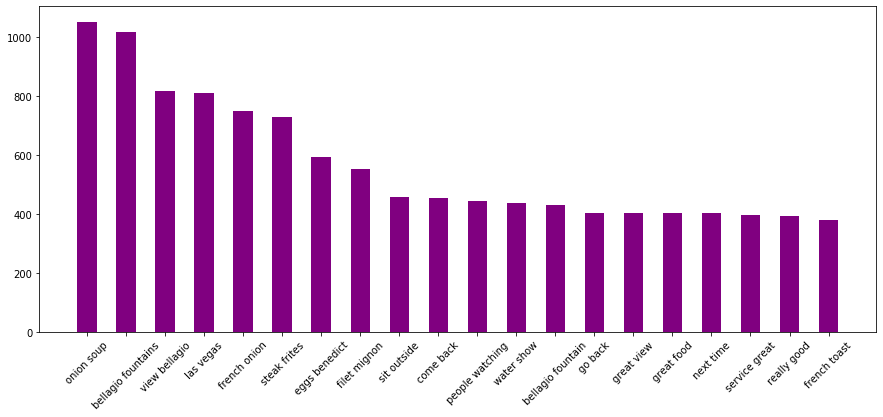

In [312]:
sum_words_bigrams = vec.sum(axis=0) 
words_freq_bigrams = [(word, sum_words_bigrams[0, idx]) for word, idx in vectorizer_det.vocabulary_.items()]
words_freq_bigrams =sorted(words_freq_bigrams, key = lambda x: x[1], reverse=True)
print(words_freq_bigrams[2:22])

x, y = zip(*words_freq_bigrams[2:22]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'purple')
plt.xticks(rotation=45)
plt.show()

The top 2 words were the name of the restaurant which I removed as it would not be useful for analysis. A lot of the bigrams are names of food, giving us information about some of the more popular food items at this restaurant (e.g. onion soup, french onion, steak frites, eggs bendict, french toast, filet mignon). There are also positive bigrams such as "service great" and "great food". the bigram "view bellagio" may indicate that there is a view of the bellagio from the restaurant.

Again there are words here that need trigram analysis to determine how they are used (e.g. "go back", "come back" - would be people come back or not?).

### Analysis - Service

Service is an important aspect of a customer's experience at a restaurant. Therefore, I will do analysis on how the word "service" is used. We saw the occurence of the word in our unigram analysis, and in this part, I will see what other words it is used it to determine whether people considered the service to be good or bad.

In [313]:
service_list = {}
for key,value in vectorizer_det.vocabulary_.items():
    if 'service' in key:
        service_list[key] = value

[('service great', 396), ('great service', 382), ('food service', 292), ('service good', 212), ('good service', 200), ('service excellent', 187), ('service food', 146), ('excellent service', 117), ('customer service', 108), ('service always', 108), ('amazing service', 63), ('service amazing', 54), ('service attentive', 52), ('service impeccable', 51), ('delicious service', 50), ('service friendly', 46), ('service top', 44), ('vegas service', 42), ('service also', 41), ('stars service', 40)]


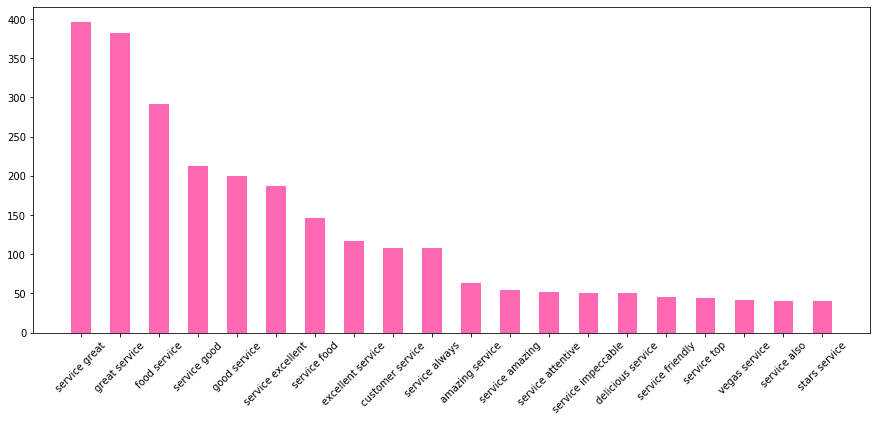

In [317]:
words_freq_service = [(word, sum_words_bigrams[0, idx]) for word, idx in service_list.items()]
words_freq_service =sorted(words_freq_service, key = lambda x: x[1], reverse=True)
print(words_freq_service[:20])

x, y = zip(*words_freq_service[:20]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'hotpink')
plt.xticks(rotation=45)
plt.show()

Its clear from the above graph that the most frequently occuring pairs of word related to 'service' were mainly positive. The top 3 describe the service as 'great', 'good' and 'excellent'. Infact there are no negative phrases about the service in the top 20 most occuring bigrams! It looks like this restaurant has service that people liked.

### Analysis - Food
The next analysis will be on the food at the restaurant.

In [309]:
food_list = {}
for key,value in vectorizer_det.vocabulary_.items():
    if 'food' in key:
        food_list[key] = value

[('great food', 404), ('food great', 363), ('food good', 357), ('good food', 301), ('food service', 292), ('french food', 216), ('food delicious', 188), ('service food', 146), ('food amazing', 142), ('quality food', 139), ('seafood crepe', 135), ('seafood platter', 129), ('food excellent', 115), ('excellent food', 96), ('delicious food', 95), ('amazing food', 89), ('food came', 86), ('food ok', 66), ('food always', 63), ('food quality', 60)]


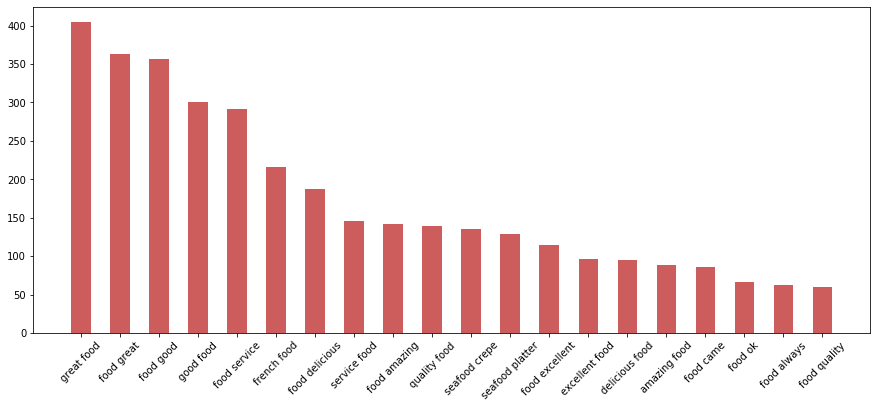

In [326]:
words_freq_food = [(word, sum_words_bigrams[0, idx]) for word, idx in food_list.items()]
words_freq_food =sorted(words_freq_food, key = lambda x: x[1], reverse=True)
print(words_freq_food[:20])

x, y = zip(*words_freq_food[:20]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'indianred')
plt.xticks(rotation=45)
plt.show()

The highest occuring bigrams all had good things to say about the food. There were again some ambiguous phrases such as "quality food" (we do not know if this is good or bad). The top 20 also had "food ok" - which is not a positive review on food. It seems the service at this restaurant is more appreciated than the food.

### Analysis - Wait Time

In [321]:
time_list = {}
for key,value in vectorizer_det.vocabulary_.items():
    if 'wait' in key:
        time_list[key] = value

[('wait staff', 141), ('cant wait', 110), ('worth wait', 109), ('long wait', 89), ('minute wait', 85), ('wait time', 72), ('wait patio', 64), ('wait long', 60), ('wait go', 54), ('wait table', 51), ('hour wait', 47), ('wait sit', 38), ('didnt wait', 34), ('wait outside', 32), ('service waiter', 32), ('still wait', 31), ('wait hour', 31), ('wait seated', 31), ('wait get', 31), ('wait come', 29)]


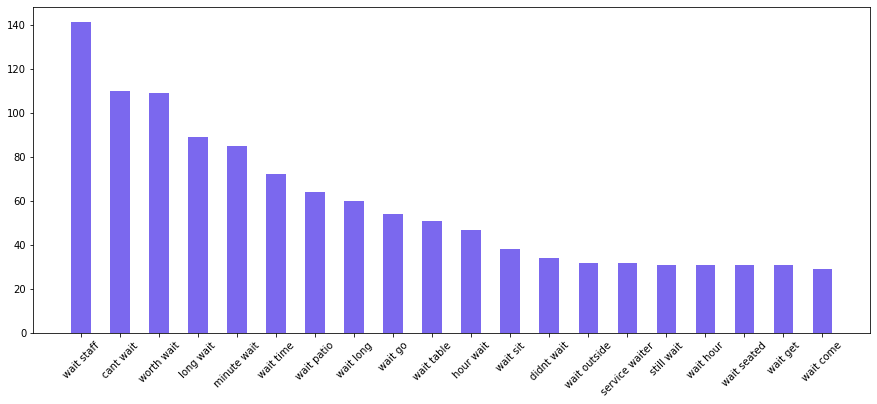

In [323]:
words_freq_time = [(word, sum_words_bigrams[0, idx]) for word, idx in time_list.items()]
words_freq_time =sorted(words_freq_time, key = lambda x: x[1], reverse=True)
print(words_freq_time[:20])

x, y = zip(*words_freq_time[:20]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'mediumslateblue')
plt.xticks(rotation=45)
plt.show()

At first glance, it seems that there is a bit of a wait time problem - either with getting a table or with the food, which cannot be discered from the data. However, there were only a few hundred reviews that seemed to express concerns with the wait time, out of the 8000+ reviews. Trigram analysis may reveal more insight about the wait times.

## Vectorization - trigram

In [327]:
vectorizer_det = CountVectorizer(ngram_range=(3,3))
vectorizer_det = vectorizer_det.fit(corpus)
vec=vectorizer_det.transform(corpus)

### Top trigrams

[('french onion soup', 706), ('view bellagio fountains', 432), ('bellagio water show', 217), ('corned beef hash', 163), ('bellagio fountain show', 162), ('great view bellagio', 158), ('view bellagio fountain', 153), ('filet mignon merlot', 146), ('bloody mary bar', 144), ('first come first', 116), ('baked goat cheese', 114), ('definitely come back', 108), ('seated right away', 102), ('across street bellagio', 99), ('view bellagio water', 99), ('food great service', 93), ('las vegas strip', 88), ('steak au poivre', 87), ('come first serve', 87)]


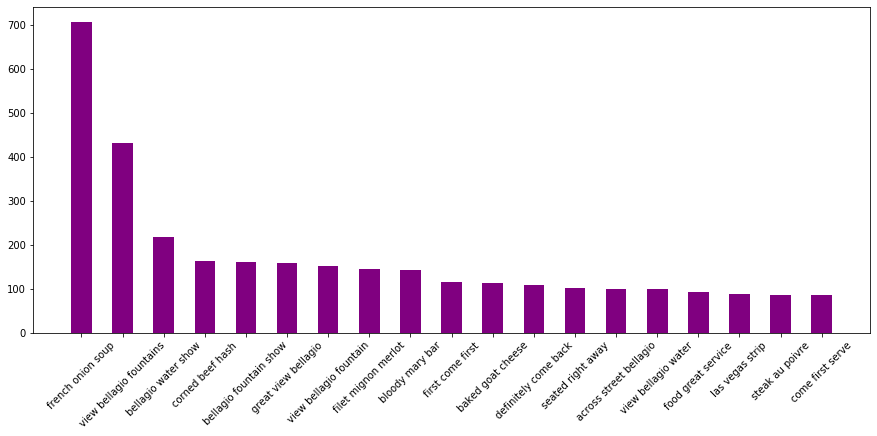

In [348]:
sum_words_trigrams = vec.sum(axis=0) 
words_freq_trigrams = [(word, sum_words_trigrams[0, idx]) for word, idx in vectorizer_det.vocabulary_.items()]
words_freq_trigrams =sorted(words_freq_trigrams, key = lambda x: x[1], reverse=True)
print(words_freq_trigrams[1:20])

x, y = zip(*words_freq_trigrams[1:20]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'purple')
plt.xticks(rotation=45)
plt.show()

In [353]:
word_dict_trigram = {}
 
listLen = len(words_freq_trigrams)

for i in range(1,listLen):
    word_dict_trigram[words_freq_trigrams[i][0]] = words_freq_trigrams[i][1]

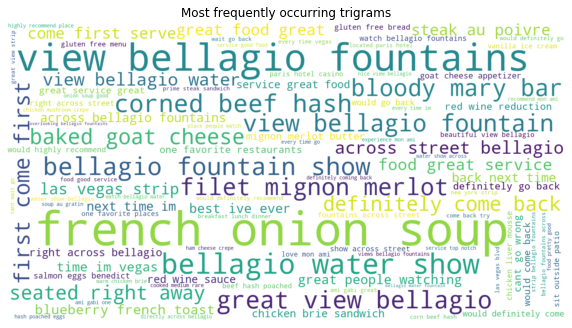

In [367]:
plt.figure(figsize=(10,10))
wordCloud = WordCloud(max_words=100, height=800, width=1500,background_color='white')
wordCloud.generate_from_frequencies(word_dict_trigram)
 
plt.title('Most frequently occurring trigrams')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Some interesting insights with the trigrams analysis: at least around a 100 people said they would definitely come back, and the frequent occurence of the words "first come first serve" seems to indicate that the restaurant may not have a reservation policy. Several people were happy that they were seated right away.

### Analysis - Wait Time

Now I will do deeper analysis on the keyword "wait" and the way it was used.

In [330]:
wait_list = {}
for key,value in vectorizer_det.vocabulary_.items():
    if 'wait' in key:
        wait_list[key] = value

[('wait go back', 46), ('cant wait go', 40), ('wait come back', 27), ('cant wait come', 25), ('wait sit outside', 21), ('didnt wait long', 17), ('wait staff attentive', 16), ('30 minute wait', 16), ('wait patio seating', 16), ('wait 15 minutes', 15), ('wait wasnt long', 15), ('well worth wait', 14), ('minute wait patio', 13), ('patio worth wait', 13), ('wait outside table', 12), ('wait sit patio', 12), ('45 minute wait', 12), ('wait table outside', 11), ('definitely worth wait', 11), ('15 minute wait', 10)]


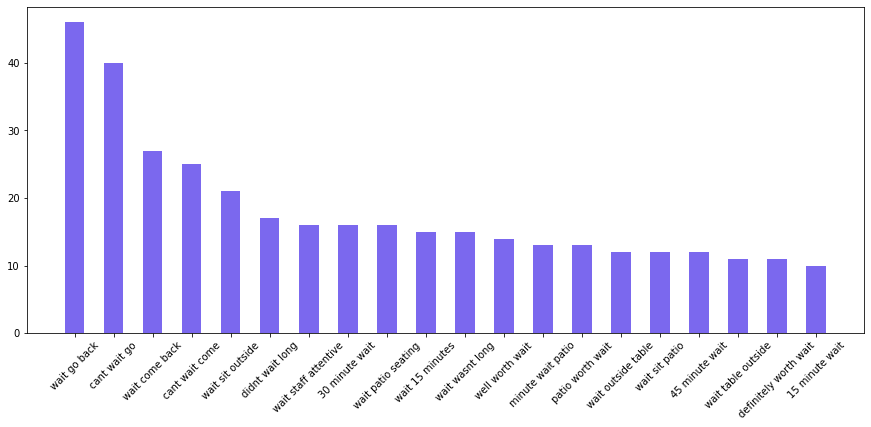

In [372]:
words_freq_wait = [(word, sum_words_trigrams[0, idx]) for word, idx in wait_list.items()]
words_freq_wait =sorted(words_freq_wait, key = lambda x: x[1], reverse=True)
print(words_freq_wait[:20])

x, y = zip(*words_freq_wait[:20]) # unpack a list of pairs into two tuples
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.5, color = 'mediumslateblue')
plt.xticks(rotation=45)
plt.show()

The trigrams give me a much better idea of the sentiments in the review! Over a hundred people said they cannot wait to return to the restaurant. There were mixed responses regarding the wait time - which most likely depended on the time they people went to the restaurant, and several people expressed that it was worth the wait. However, there were not many people that commented on the wait time in their reviews, compared to the number of reviews that shared their feelings about the food and service.